In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, 'figure.figsize': (6.0, 4.0)}
%matplotlib inline

import abtem
import matplotlib.pyplot as plt
import numpy as np
from ase.build import mx2
from ase.io import read

abtem.config.set({"local_diagnostics.progress_bar": False});

# Partial coherence

In our introduction to the contrast transfer function, we described how partial coherence may be approximated by multiplication with an envelope function. This approach is not always appropriate for simulating experiments with plane wave illumination and it is never appropriate for simulating experiments with a convergent beam.  

## Partial coherence with plane waves

In [250]:
exit_wave = abtem.PlaneWave(energy=80e3, sampling=0.05).multislice(mx2(vacuum=2))

In [251]:
Cs = -20e-6 * 1e10
focal_spread = 52.50

# Create coherent CTF
ctf_coherent = abtem.CTF(Cs=Cs, energy=80e3)
ctf_coherent.defocus = ctf_coherent.scherzer_defocus
ctf_coherent.semiangle_cutoff = ctf_coherent.crossover_angle

# Create CTF with temporal coherence envelope
ctf_quasi_coherent = ctf_coherent.copy()
ctf_quasi_coherent.focal_spread = focal_spread

# Run multislice and get intensity
image_coherent = exit_wave.apply_ctf(ctf_coherent).intensity()
image_quasi_coherent = exit_wave.apply_ctf(ctf_quasi_coherent).intensity()

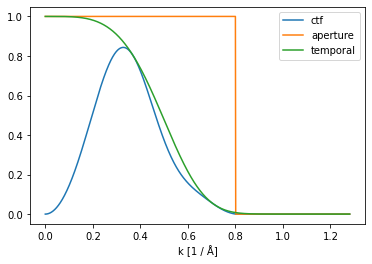

In [252]:
ctf_quasi_coherent.profiles().show();

In [253]:
ctf_incoherent = ctf_coherent.copy()

defocus = abtem.distributions.gaussian(
    center=ctf_incoherent.scherzer_defocus,
    standard_deviation=focal_spread,
    num_samples=5,
    sampling_limit=1.,
)

ctf_incoherent.defocus = defocus

In [254]:
images_incoherent = exit_wave.apply_ctf(ctf_incoherent).intensity()

images_incoherent

-------------------------------------------------------

type           label    coordinates
-------------  -------  -----------------------
ParameterAxis  C10 [Å]  164.42 138.17 ... 59.42
RealSpaceAxis  x [Å]    0.00 0.05 ... 3.13
RealSpaceAxis  y [Å]    0.00 0.05 ... 5.46

        bytes       shape         count     type
------  ----------  ------------  --------  -------------
array   138.75 kiB  (5, 64, 111)  7 tasks   float32
chunks  138.75 kiB  (5, 64, 111)  1 chunks  numpy.ndarray

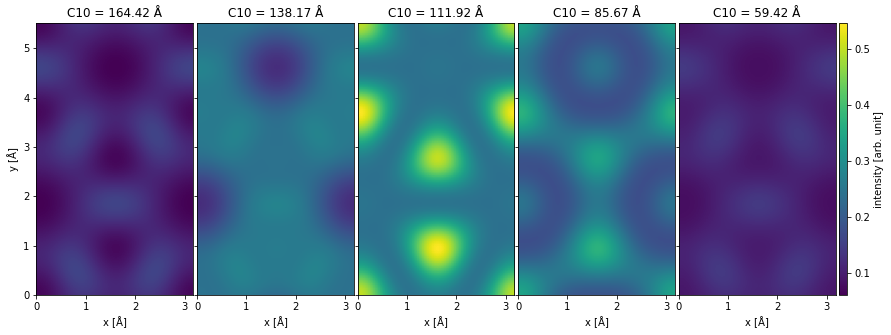

In [255]:
images_incoherent.show(
    explode=True,
    figsize=(18, 5),
    common_color_scale=True,
    image_grid_kwargs={"axes_pad": 0.05},
    cbar=True,
);

In [256]:
image_incoherent = images_incoherent.sum(0)

stack = abtem.stack(
    [image_coherent, image_quasi_coherent, image_incoherent],
    ("coherent", "quasi-coherent", "incoherent"),
)

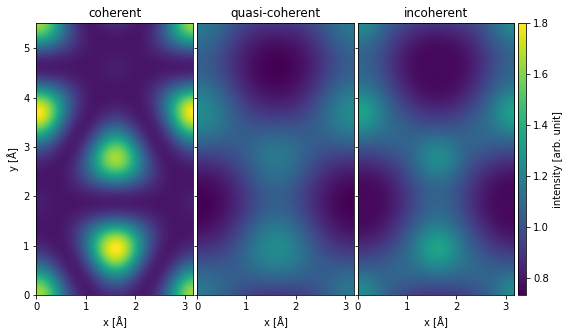

In [257]:
stack.show(
    common_color_scale=True,
    explode=True,
    cbar=True,
    figsize=(18, 5),
    image_grid_kwargs={"axes_pad": 0.05},
);

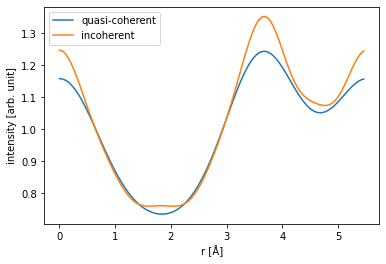

In [249]:
stack[1:].interpolate_line(start=(0, 0), end=(0, stack.extent[1])).show();

## Partial coherence with probes